In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# Dataset Loading & Preprocessing

The Breast Cancer Wisconsin dataset is loaded and split into training and testing sets. Feature scaling is applied to ensure all features contribute equally during regularized training.

In [12]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Helper Function for Experiments

In [13]:
results = []
weight_dict = {}

def run_experiment(name, model, lam=0):
    model.fit(X_train_scaled, y_train)

    # Predictions
    train_probs = model.predict_proba(X_train_scaled)
    test_probs = model.predict_proba(X_test_scaled)
    y_pred = model.predict(X_test_scaled)

    # Metrics
    train_loss = log_loss(y_train, train_probs)
    test_loss = log_loss(y_test, test_probs)
    accuracy = accuracy_score(y_test, y_pred)

    # Weight Analysis
    weights = model.coef_.flatten()
    sparsity = np.sum(np.isclose(weights, 0, atol=1e-4))
    magnitude = np.linalg.norm(weights)

    if name == "Baseline":
        cost = train_loss
    elif name == "L1 (Lasso)":
        cost = train_loss + (lam * np.sum(np.abs(weights)))
    elif name == "L2 (Ridge)":
        cost = train_loss + (0.5 * lam * np.sum(weights**2))
    else:
        cost = train_loss + (0.5 * lam * (np.sum(np.abs(weights)) + np.sum(weights**2)))

    results.append({
        "Model": name,
        "Train Loss": round(train_loss, 4),
        "Val Loss": round(test_loss, 4),
        "Cost": round(cost, 4),
        "Accuracy": round(accuracy, 4),
        "Zero Weights": sparsity,
        "Weight Norm": round(magnitude, 4)
    })
    weight_dict[name] = weights

A reusable function is created to train models, compute losses, accuracy, cost functions, and analyze weight behavior for fair comparison.

# Baseline Model (No Regularization)

In [14]:
run_experiment(
    "Baseline",
    LogisticRegression(penalty=None)
)

The baseline model fits the data without regularization and shows signs of overfitting due to very large weight magnitudes.

# L1 Regularization (Lasso)

In [15]:
lam = 0.5
C_val = 1 / lam

run_experiment(
    "L1 (Lasso)",
    LogisticRegression(penalty='l1', solver='liblinear', C=C_val),
    lam
)

L1 regularization introduces sparsity by driving irrelevant feature weights to zero, improving model interpretability.

# L2 Regularization (Ridge)

In [16]:
run_experiment(
    "L2 (Ridge)",
    LogisticRegression(penalty='l2', C=C_val),
    lam
)


L2 regularization reduces weight magnitudes without eliminating features, leading to a more stable and generalized model.

# Elastic Net Regularization

In [17]:
run_experiment(
    "Elastic Net",
    LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=0.5,
        C=C_val,
        max_iter=5000
    ),
    lam
)


Elastic Net combines L1 sparsity and L2 stability, achieving the best balance between feature selection and generalization.

# Comparative Results Table

In [18]:
df_results = pd.DataFrame(results)
print("--- COMPARATIVE ANALYSIS TABLE ---")
print(df_results.to_string(index=False))

--- COMPARATIVE ANALYSIS TABLE ---
      Model  Train Loss  Val Loss    Cost  Accuracy  Zero Weights  Weight Norm
   Baseline      0.0002    1.9963  0.0002    0.9386             0     743.1717
 L1 (Lasso)      0.0445    0.0755 10.5964    0.9649            13       6.9018
 L2 (Ridge)      0.0484    0.0610  5.4765    0.9737             0       4.6596
Elastic Net      0.0477    0.0627 11.0904    0.9825             4       4.8929


The table summarizes the performance of all models, highlighting improvements in accuracy and generalization due to regularization.

# Loss Comparison Plot

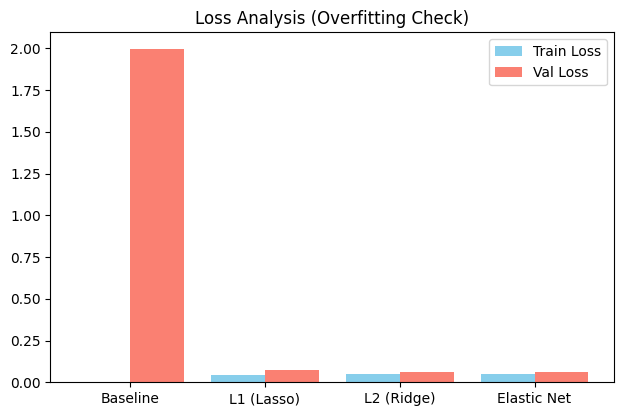

In [19]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
x_axis = np.arange(len(df_results))
plt.bar(x_axis - 0.2, df_results['Train Loss'], 0.4, label='Train Loss', color='skyblue')
plt.bar(x_axis + 0.2, df_results['Val Loss'], 0.4, label='Val Loss', color='salmon')
plt.xticks(x_axis, df_results['Model'])
plt.title("Loss Analysis (Overfitting Check)")
plt.legend()

Regularized models reduce the gap between training and validation loss, indicating improved generalization.

# Weight Sparsity Visualization

/tmp/ipython-input-1991871980.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Zero Weights", data=df_results, palette="viridis")


Text(0.5, 1.0, 'Number of Weights Driven to Zero')

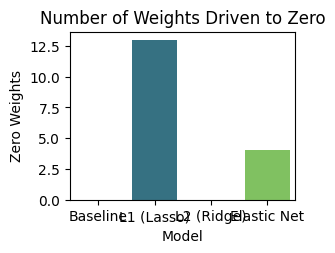

In [20]:
plt.subplot(2, 2, 2)
sns.barplot(x="Model", y="Zero Weights", data=df_results, palette="viridis")
plt.title("Number of Weights Driven to Zero")

L1 and Elastic Net models produce sparse solutions, while L2 retains all features.

# Weight Magnitude Comparison

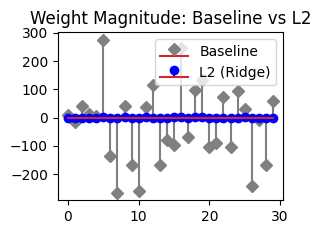

In [21]:
plt.subplot(2, 2, 3)
plt.stem(weight_dict['Baseline'], linefmt='grey', markerfmt='D', label='Baseline')
plt.stem(weight_dict['L2 (Ridge)'], linefmt='blue', markerfmt='o', label='L2 (Ridge)')
plt.title("Weight Magnitude: Baseline vs L2")
plt.legend()

Regularization significantly reduces extreme weight values compared to the baseline model.

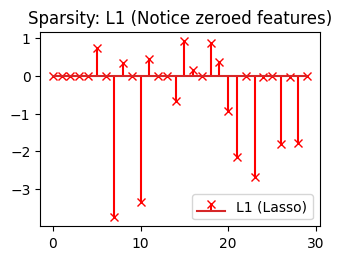

In [22]:
plt.subplot(2, 2, 4)
plt.stem(weight_dict['L1 (Lasso)'], linefmt='red', markerfmt='x', label='L1 (Lasso)')
plt.title("Sparsity: L1 (Notice zeroed features)")
plt.legend()

plt.tight_layout()
plt.show()

# Hyperparameter Sensitivity Analysis

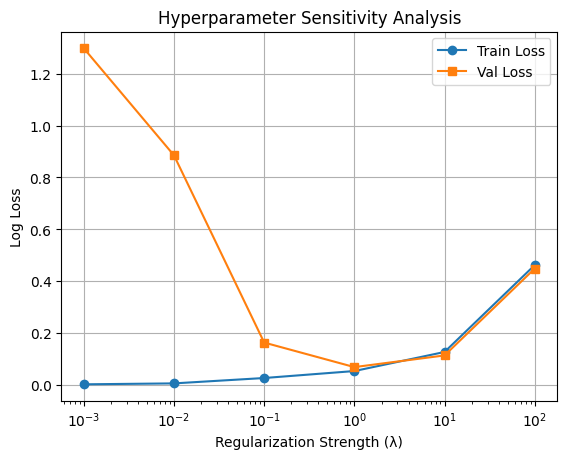

In [23]:
lambdas = [0.001, 0.01, 0.1, 1, 10, 100]
sensitivity = []

for l in lambdas:
    model = LogisticRegression(penalty='l1', solver='liblinear', C=1/l)
    model.fit(X_train_scaled, y_train)

    sensitivity.append({
        'lambda': l,
        'train_loss': log_loss(y_train, model.predict_proba(X_train_scaled)),
        'val_loss': log_loss(y_test, model.predict_proba(X_test_scaled))
    })

sens_df = pd.DataFrame(sensitivity)

plt.plot(sens_df['lambda'], sens_df['train_loss'], marker='o', label='Train Loss')
plt.plot(sens_df['lambda'], sens_df['val_loss'], marker='s', label='Val Loss')
plt.xscale('log')
plt.xlabel("Regularization Strength (λ)")
plt.ylabel("Log Loss")
plt.title("Hyperparameter Sensitivity Analysis")
plt.legend()
plt.grid(True)
plt.show()

Increasing regularization strength reveals the trade-off between underfitting and overfitting, validating the importance of optimal λ selection.

For small λ, the model overfits with low training loss and high validation loss.
As λ increases, overfitting reduces and validation loss improves.
At very high λ, the model underfits and both losses increase.
L1 increases sparsity, L2 shrinks weights, and Elastic Net balances both.
The optimal λ gives the best trade-off between bias and variance.

# Interpretation & Regularization

The baseline model overfits due to large weight values.
L1 regularization creates sparsity by setting some weights to zero.
L2 regularization reduces weight magnitudes and improves stability.
Elastic Net combines both sparsity and weight shrinkage and achieves the highest validation accuracy.
Hence, Elastic Net is the most suitable regularization technique for this dataset.